In [242]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sqlalchemy import create_engine
import MySQLdb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from statsmodels.discrete.discrete_model import Logit, MNLogit
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
import statsmodels.api as st
import numpy as np
import scikitplot as skplt
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 50)

In [174]:
# import data
# feature engineering?
# k fold
# hyperparameter tuning
# Hospital Insurance -> classification
# Hospital Utilisation -> classification
# performance measure

In [175]:
# DB Connection
myvars = {}
with open("../risaac-mysql-password") as myfile:
    for line in myfile:
        name, var = line.partition(":")[::2]
        myvars[name.strip()] = var.strip()
        
myvars['DB databasename'] = 'I501saptpurkFall22grp_06_db'

conn = MySQLdb.connect(host="localhost", user=myvars['DB username'], passwd=myvars['DB password'], db=myvars['DB databasename'])
cursor = conn.cursor()

In [176]:
df = pd.read_sql('select * from P_DEMO_HUQ_HIQ', conn)

In [177]:
# remove INDFMPIR and replace with INDFMPIR_imputed
df = df.drop("INDFMPIR", axis = 1)
df = df[~df.isna().any(axis = 1)]
df = df.rename(columns = {"INDFMPIR_imputed":"INDFMPIR"})

# copy dataframe
df_temp = df.copy()

In [178]:
# segragating features into nominal, ordinal and numeric
nominal_cols = [
    "RIAGENDR"
    ,"RIDRETH3"
    ,"DMDBORN4"
    ,"DMDMARTZ"
    ,"RIDEXPRG"
    ,"SIALANG"
    ,"SIAPROXY"
    ,"SIAINTRP"
    ,"HUQ030"
    ,"HUQ071"
    ,"HUQ090"
    ,"HIQ011"
    ,'HIQ032A'
    ,'HIQ032B'
    ,'HIQ032C'
    ,'HIQ032D'
    ,'HIQ032E'
    ,'HIQ032H'
    ,'HIQ032I'
    ,'HIQ270'
    ,'HIQ210'
]

ordinal_cols = [
    "DMDYRUSZ"
    ,"DMDEDUC2"
    ,"HUQ010"
    ,"HUQ051"
]

numeric_cols = [
    "RIDAGEYR"
    ,"RIDAGEMN"
    ,"INDFMPIR"
]

In [179]:
# columns to one hot encode
# RIDRETH3
# RIDRETH1
# DMDBORN4 - Encode to 0,1
# DMDMARTZ
# RIDEXPRG
# SIALANG - Encode to 0,1
# SIAPROXY - Encode to 0,1
# SIAINTRP - Encode to 0,1

# HUQ030
# HUQ071 - Encode to 0,1
# HUQ090 - Encode to 0,1
# HIQ011 - Encode to 0,1
# HIQ032A - Encode to 0,1

# HIQ270
# HIQ210

In [180]:
# covert 1=>0, 2=>1
enc_1_0_cols = ["DMDBORN4"
               ,"SIALANG"
               ,"HIQ032A"]
for col in enc_1_0_cols:
    df[col] = np.where(df[col] == 1, 0, 1)
    
# covert 1=>1, 2=>0
enc_1_0_cols = ["SIAPROXY"
               ,"SIAINTRP"
               ,"HUQ071"
               ,"HUQ090"
               ,"HIQ011"
               ,"HIQ032A"]
for col in enc_1_0_cols:
    df[col] = np.where(df[col] == 1, 1, 0)


In [181]:
one_hot_enc_cols = ["RIDRETH3"
                   ,"RIDRETH1"
                   ,"DMDMARTZ"
                   ,"RIDEXPRG"
                   ,"HUQ030"
                   ,"HIQ270"
                   ,"HIQ210"]

In [182]:
df[["HUQ051","HUQ030","HUQ010","HIQ210","HIQ270"]] = df[["HUQ051","HUQ030","HUQ010","HIQ210","HIQ270"]].astype("Int32")

In [183]:
demo_cols = [
    "RIAGENDR"
    ,"RIDAGEMN"
    ,"RIDRETH1"
    ,"RIDRETH3"
    ,"DMDBORN4"
    ,"DMDMARTZ"
    ,"RIDEXPRG"
    ,"SIALANG"
    ,"SIAPROXY"
    ,"SIAINTRP"
    ,"DMDYRUSZ"
    ,"DMDEDUC2"
    ,"INDFMPIR"
]

huq_cols = ["HUQ010"
           ,"HUQ071"
           ,"HUQ090"
           ,"HUQ051"]

hiq_cols = ["HIQ011"
    ,'HIQ032A'
    ,'HIQ032B'
    ,'HIQ032C'
    ,'HIQ032D'
    ,'HIQ032E'
    ,'HIQ032H'
    ,'HIQ032I'
    ,'HIQ270'
    ,'HIQ210']

### Hospital Utilisation Prediction Using Demographics & Health Insurance

In [184]:
target_col = "HUQ051"

In [185]:
df.loc[df["HUQ051"].isin([0,1,2]), "HUQ051"] = 0
df.loc[df["HUQ051"].isin([3,4,5]), "HUQ051"] = 1
# df.loc[df["HUQ051"].isin([4,5]), "HUQ051"] = 2
df.loc[df["HUQ051"] >= 6, "HUQ051"] = 2

In [186]:
df_dum = pd.get_dummies(df[demo_cols + hiq_cols + huq_cols + [target_col]], columns = [col for col in one_hot_enc_cols if col in demo_cols + huq_cols + hiq_cols], drop_first = True)

In [187]:
df_dum = st.add_constant(df, prepend = False)

In [189]:
X_train, X_test, y_train, y_test = train_test_split(df_dum[df_dum.columns[df_dum.columns != target_col]], 
                                                    df_dum[target_col], 
                                                    test_size=0.20
                                                    )

In [190]:
for col in X_train.columns:
    X_train[col] = X_train[col].astype(float)
    
for col in X_test.columns:
    X_test[col] = X_test[col].astype(float)

### Logistic Regression

In [191]:
# based on statsmodel multinomial logit
mdl = st.MNLogit(y_train, X_train)
mdl_fit = mdl.fit()
print(mdl_fit.summary())

Optimization terminated successfully.
         Current function value: 0.710183
         Iterations 7
                          MNLogit Regression Results                          
Dep. Variable:                 HUQ051   No. Observations:                11997
Model:                        MNLogit   Df Residuals:                    11935
Method:                           MLE   Df Model:                           60
Date:                Tue, 29 Nov 2022   Pseudo R-squ.:                  0.1390
Time:                        14:24:00   Log-Likelihood:                -8520.1
converged:                       True   LL-Null:                       -9895.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
  HUQ051=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SEQN        5.196e-06   5.12e-06      1.014      0.311   -4.85e-06    1.52e-05
SDDSRVYR      -0.0514      0.

In [192]:
out = mdl_fit.summary()

In [195]:
# getting p values
out_df = pd.DataFrame(out.tables[1])
out_temp = out_df.loc[:31]
out_temp.columns = out_temp.loc[0]
out_temp

,HUQ051=1,coef,std err,z,P>|z|,[0.025,0.975]
0,HUQ051=1,coef,std err,z,P>|z|,[0.025,0.975]
1,SEQN,5.196e-06,5.12e-06,1.014,0.311,-4.85e-06,1.52e-05
2,SDDSRVYR,-0.0514,0.013,-3.986,0.000,-0.077,-0.026
3,RIDSTATR,0.1806,0.089,2.031,0.042,0.006,0.355
4,RIAGENDR,0.1495,0.050,2.986,0.003,0.051,0.248
5,RIDAGEYR,-3.2116,0.180,-17.846,0.000,-3.564,-2.859
6,RIDAGEMN,0.2682,0.015,17.842,0.000,0.239,0.298
7,RIDRETH1,0.0403,0.075,0.535,0.593,-0.107,0.188
8,RIDRETH3,0.0022,0.054,0.040,0.968,-0.104,0.109
9,DMDBORN4,0.0139,0.139,0.100,0.920,-0.259,0.286


In [196]:
model = LogisticRegression()

In [197]:
grid_vals = {'penalty': ['l2'], 'C': [0.01,0.1], 'max_iter':[100, 150, 200, 300], 'solver':['newton-cg', 'lbfgs', 'saga']}
# grid_vals = {'penalty': ['l2'], 'C': [0.001,0.01,0.1,1]}
grid_lr = GridSearchCV(estimator=model, param_grid=grid_vals, scoring='f1_micro', 
                       cv=3, refit=True, return_train_score=True, error_score='raise', n_jobs=4) 

In [198]:
y_train = y_train.astype("float")

In [199]:
grid_lr.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:456: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:305: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSear

GridSearchCV(cv=3, error_score='raise', estimator=LogisticRegression(),
             n_jobs=4,
             param_grid={'C': [0.01, 0.1], 'max_iter': [100, 150, 200, 300],
                         'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'saga']},
             return_train_score=True, scoring='f1_micro')

In [200]:
pd.DataFrame(grid_lr.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1.522565,0.114811,0.005073,0.001921,0.01,100,l2,newton-cg,"{'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...",0.685671,0.688172,0.686422,0.686755,0.001048,8,0.685921,0.687172,0.688297,0.687130,0.000970
1,0.063567,0.000546,0.003470,0.000069,0.01,100,l2,lbfgs,"{'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...",0.667917,0.667917,0.667667,0.667834,0.000118,9,0.667792,0.667792,0.667917,0.667834,0.000059
2,0.497413,0.084220,0.003179,0.000582,0.01,100,l2,saga,"{'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...",0.667917,0.667917,0.667667,0.667834,0.000118,9,0.667792,0.667792,0.667917,0.667834,0.000059
3,1.409980,0.160441,0.003269,0.000457,0.01,150,l2,newton-cg,"{'C': 0.01, 'max_iter': 150, 'penalty': 'l2', ...",0.685671,0.688172,0.686672,0.686838,0.001028,5,0.685921,0.687172,0.688422,0.687172,0.001021
4,0.049823,0.000370,0.002700,0.000040,0.01,150,l2,lbfgs,"{'C': 0.01, 'max_iter': 150, 'penalty': 'l2', ...",0.667917,0.667917,0.667667,0.667834,0.000118,9,0.667792,0.667792,0.667917,0.667834,0.000059
5,0.725640,0.130096,0.005212,0.003566,0.01,150,l2,saga,"{'C': 0.01, 'max_iter': 150, 'penalty': 'l2', ...",0.667917,0.667917,0.667667,0.667834,0.000118,9,0.667792,0.667792,0.667917,0.667834,0.000059
6,1.412043,0.169618,0.003861,0.000038,0.01,200,l2,newton-cg,"{'C': 0.01, 'max_iter': 200, 'penalty': 'l2', ...",0.685671,0.688172,0.686672,0.686838,0.001028,5,0.685921,0.687172,0.688422,0.687172,0.001021
7,0.065572,0.000500,0.003411,0.000033,0.01,200,l2,lbfgs,"{'C': 0.01, 'max_iter': 200, 'penalty': 'l2', ...",0.667917,0.667917,0.667667,0.667834,0.000118,9,0.667792,0.667792,0.667917,0.667834,0.000059
8,0.983855,0.142127,0.004147,0.001344,0.01,200,l2,saga,"{'C': 0.01, 'max_iter': 200, 'penalty': 'l2', ...",0.667917,0.667917,0.667667,0.667834,0.000118,9,0.667792,0.667792,0.667917,0.667834,0.000059
9,1.352188,0.159118,0.003127,0.000501,0.01,300,l2,newton-cg,"{'C': 0.01, 'max_iter': 300, 'penalty': 'l2', ...",0.685671,0.688172,0.686672,0.686838,0.001028,5,0.685921,0.687172,0.688422,0.687172,0.001021


In [201]:
grid_lr.best_estimator_

LogisticRegression(C=0.1, solver='newton-cg')

In [202]:
y_pred = grid_lr.predict(X_test)
out = pd.DataFrame({"y_pred":y_pred, "y_label":y_test})

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

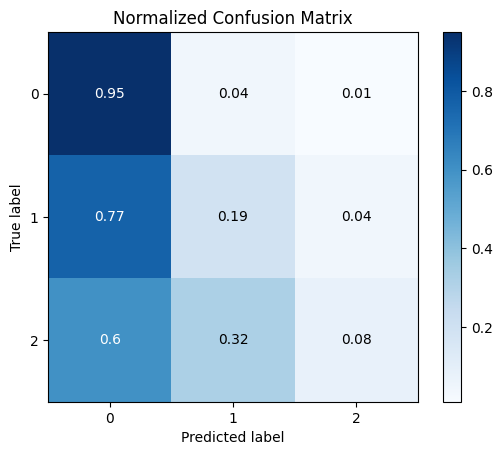

In [214]:
skplt.metrics.plot_confusion_matrix(out["y_label"].tolist(), out["y_pred"].tolist(), normalize=True)

In [215]:
y_pred = grid_lr.predict_proba(X_test)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

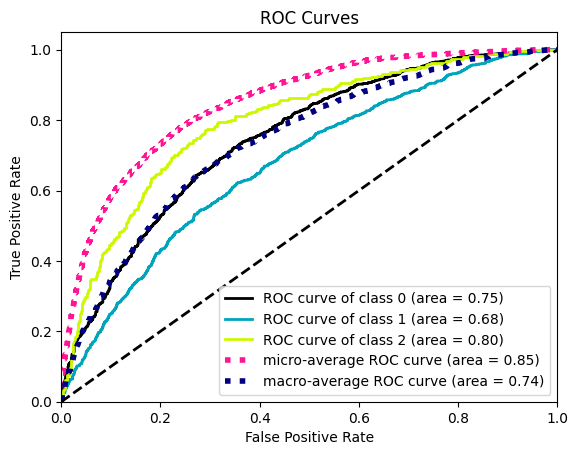

In [219]:
skplt.metrics.plot_roc(y_test.tolist(), y_pred)

### XGBoost

In [220]:
model = XGBClassifier()
grid_vals = {"n_estimators":[400,500,600], "learning_rate" : [0.1, 0.01], "max_depth" : [2,3,4], "subsample":[0.7, 0.8],
                      "colsample_bytree":[0.7,0.8], 'reg_alpha':[1e-5, 1e-2]}

In [221]:
# grid_vals = {'penalty': ['l2'], 'C': [0.01,0.1], 'max_iter':[100, 150, 200, 300], 'solver':['newton-cg', 'lbfgs', 'saga']}
# grid_vals = {'penalty': ['l2'], 'C': [0.001,0.01,0.1,1]}
grid_lr = GridSearchCV(estimator=model, param_grid=grid_vals, scoring='f1_micro', 
                       cv=3, refit=True, return_train_score=True, error_score='raise', n_jobs=4) 

In [222]:
grid_lr.fit(X_train, y_train)

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__

GridSearchCV(cv=3, error_score='raise',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.7, 0.8],
                         'learning_rate': [0.1, 0.01], 'max_depth': [2, 3, 4],
                         'n_estimators': [400, 500, 600],
                         'reg_alpha': [1e-05, 0.01], 'subsample': [0.7, 0.8]},
             return_train_score=True, scoring='f1_micro')

In [223]:
pd.DataFrame(grid_lr.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_reg_alpha,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,1.937640,0.038367,0.009726,0.000678,0.7,0.1,2,400,0.00001,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",0.700425,0.698175,0.695674,0.698091,0.001941,64,0.728557,0.731558,0.734434,0.731516,0.002399
1,1.946825,0.127255,0.022535,0.008954,0.7,0.1,2,400,0.00001,0.8,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",0.694924,0.699675,0.696174,0.696924,0.002011,83,0.728182,0.731933,0.733933,0.731350,0.002384
2,1.783337,0.042790,0.009138,0.000525,0.7,0.1,2,400,0.01,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",0.700425,0.699675,0.695924,0.698675,0.001969,52,0.727432,0.730808,0.733308,0.730516,0.002408
3,1.726842,0.013133,0.010353,0.001503,0.7,0.1,2,400,0.01,0.8,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",0.696174,0.700175,0.696674,0.697674,0.001780,69,0.729057,0.732308,0.733683,0.731683,0.001940
4,2.161513,0.024225,0.011869,0.000880,0.7,0.1,2,500,0.00001,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",0.698425,0.698925,0.695424,0.697591,0.001546,70,0.731808,0.735809,0.736809,0.734809,0.002161
5,2.270259,0.129639,0.012470,0.001061,0.7,0.1,2,500,0.00001,0.8,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",0.695924,0.698675,0.695924,0.696841,0.001297,86,0.733308,0.737434,0.738935,0.736559,0.002379
6,2.244400,0.131053,0.011756,0.001503,0.7,0.1,2,500,0.01,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",0.698675,0.697924,0.695674,0.697424,0.001275,76,0.731433,0.735434,0.737934,0.734934,0.002678
7,2.338407,0.129043,0.013303,0.000653,0.7,0.1,2,500,0.01,0.8,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",0.696424,0.699175,0.694674,0.696758,0.001853,89,0.732683,0.736184,0.738435,0.735767,0.002366
8,2.646032,0.073707,0.015527,0.001337,0.7,0.1,2,600,0.00001,0.7,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",0.697924,0.698425,0.693673,0.696674,0.002132,90,0.736809,0.740685,0.743561,0.740352,0.002766
9,2.606606,0.058581,0.014831,0.001366,0.7,0.1,2,600,0.00001,0.8,"{'colsample_bytree': 0.7, 'learning_rate': 0.1...",0.697174,0.698675,0.694674,0.696841,0.001650,86,0.736309,0.740310,0.744186,0.740268,0.003216


In [224]:
grid_lr.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=600,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=1e-05, ...)

In [225]:
y_pred = grid_lr.predict(X_test)
out = pd.DataFrame({"y_pred":y_pred, "y_label":y_test})

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

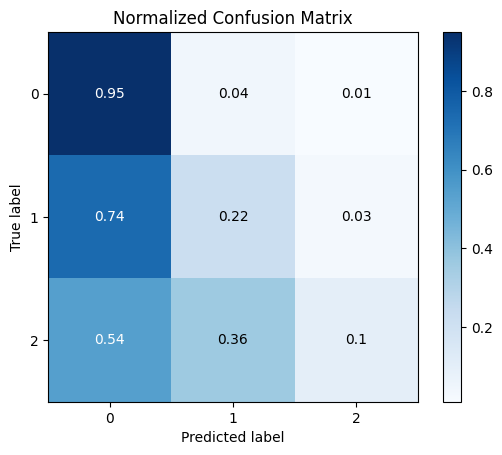

In [226]:
skplt.metrics.plot_confusion_matrix(out["y_label"].tolist(), out["y_pred"].tolist(), normalize=True)

In [227]:
y_pred = grid_lr.predict_proba(X_test)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

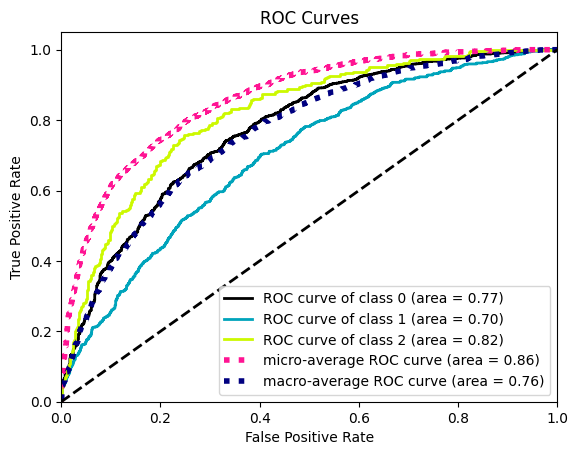

In [228]:
skplt.metrics.plot_roc(y_test.tolist(), y_pred)

### LightGBM

In [229]:
model = LGBMClassifier()

In [230]:
grid_vals = {'learning_rate': [0.01, 0.1], 'n_estimators': [100, 200, 300],
               'num_leaves': [6, 12, 16,24], 'boosting_type': ['gbdt', 'dart'], 
               'colsample_bytree': [0.65, 0.75, 0.8], 
               'subsample': [0.7, 0.75], 'reg_alpha': [1e-5, 1e-2],
               'reg_lambda': [1e-5, 1e-2]}

In [231]:
grid_lr = GridSearchCV(estimator=model, param_grid=grid_vals, scoring='f1_micro', 
                       cv=3, refit=True, return_train_score=True, error_score='raise', n_jobs=4) 

In [232]:
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise', estimator=LGBMClassifier(), n_jobs=4,
             param_grid={'boosting_type': ['gbdt', 'dart'],
                         'colsample_bytree': [0.65, 0.75, 0.8],
                         'learning_rate': [0.01, 0.1],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [6, 12, 16, 24],
                         'reg_alpha': [1e-05, 0.01],
                         'reg_lambda': [1e-05, 0.01],
                         'subsample': [0.7, 0.75]},
             return_train_score=True, scoring='f1_micro')

In [233]:
pd.DataFrame(grid_lr.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_boosting_type,param_colsample_bytree,param_learning_rate,param_n_estimators,param_num_leaves,param_reg_alpha,param_reg_lambda,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.281656,0.010201,0.009358,0.000155,gbdt,0.65,0.01,100,6,0.00001,0.00001,0.7,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",0.669417,0.667417,0.676669,0.671168,0.003975,1113,0.668667,0.669667,0.681795,0.673377,0.005967
1,0.269365,0.009201,0.009595,0.000345,gbdt,0.65,0.01,100,6,0.00001,0.00001,0.75,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",0.669417,0.667417,0.676669,0.671168,0.003975,1113,0.668667,0.669667,0.681795,0.673377,0.005967
2,0.276463,0.011995,0.008907,0.000256,gbdt,0.65,0.01,100,6,0.00001,0.01,0.7,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",0.669417,0.667417,0.676669,0.671168,0.003975,1113,0.668667,0.669667,0.681795,0.673377,0.005967
3,0.255745,0.003016,0.007757,0.000159,gbdt,0.65,0.01,100,6,0.00001,0.01,0.75,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",0.669417,0.667417,0.676669,0.671168,0.003975,1113,0.668667,0.669667,0.681795,0.673377,0.005967
4,0.174459,0.007690,0.010332,0.002866,gbdt,0.65,0.01,100,6,0.01,0.00001,0.7,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",0.669417,0.667417,0.676669,0.671168,0.003975,1113,0.668667,0.669667,0.681795,0.673377,0.005967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,1.385608,0.024330,0.024764,0.000903,dart,0.8,0.1,300,24,0.00001,0.01,0.75,"{'boosting_type': 'dart', 'colsample_bytree': ...",0.693673,0.698925,0.696924,0.696507,0.002164,577,0.802701,0.795449,0.802326,0.800158,0.003334
1148,1.397318,0.025329,0.024375,0.000542,dart,0.8,0.1,300,24,0.01,0.00001,0.7,"{'boosting_type': 'dart', 'colsample_bytree': ...",0.691673,0.699675,0.695924,0.695757,0.003269,625,0.801200,0.797699,0.803076,0.800658,0.002228
1149,1.381007,0.020000,0.024609,0.000121,dart,0.8,0.1,300,24,0.01,0.00001,0.75,"{'boosting_type': 'dart', 'colsample_bytree': ...",0.691673,0.699675,0.695924,0.695757,0.003269,625,0.801200,0.797699,0.803076,0.800658,0.002228
1150,1.410014,0.014873,0.024975,0.001112,dart,0.8,0.1,300,24,0.01,0.01,0.7,"{'boosting_type': 'dart', 'colsample_bytree': ...",0.693423,0.702176,0.692173,0.695924,0.004450,607,0.803326,0.793198,0.802201,0.799575,0.004532


In [307]:
grid_lr.best_estimator_

array([0, 0, 1, ..., 0, 0, 0])

In [316]:
y_pred = grid_lr.predict(X_test)
out = pd.DataFrame({"y_pred":y_pred.flatten(), "y_label":y_test})

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

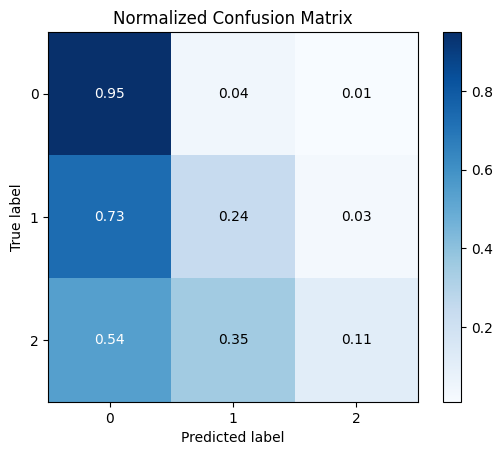

In [317]:
skplt.metrics.plot_confusion_matrix(out["y_label"].tolist(), out["y_pred"].tolist(), normalize=True)

In [318]:
y_pred = grid_lr.predict_proba(X_test)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

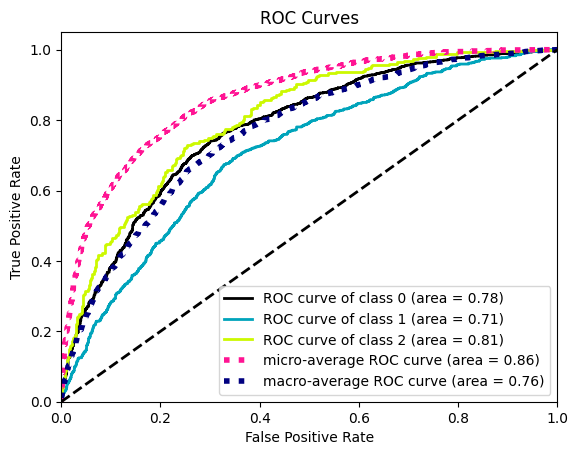

In [319]:
skplt.metrics.plot_roc(y_test.tolist(), y_pred)

### CatBoost

In [246]:
df

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,DMDBORN4,DMDYRUSZ,DMDEDUC2,DMDMARTZ,RIDEXPRG,SIALANG,SIAPROXY,SIAINTRP,INDFMPIR,HUQ010,HUQ030,HUQ051,HUQ071,HUQ090,HIQ011,HIQ032A,HIQ032B,HIQ032C,HIQ032D,HIQ032E,HIQ032H,HIQ032I,HIQ270,HIQ210
0,109263,66,2,0,2,24,5,6,0,5,6,4,4,0,1,0,4.66,1,1,0,0,0,1,0,0,0,0,0,0,0,1,2
1,109264,66,2,1,13,156,1,1,0,5,6,4,4,0,1,0,0.83,2,1,0,0,1,1,1,0,0,0,0,1,0,1,2
2,109265,66,2,0,2,24,3,3,0,5,6,4,4,0,1,0,3.06,1,1,0,0,0,1,0,0,0,1,0,0,0,1,2
3,109266,66,2,1,29,348,5,6,1,2,5,3,2,0,0,0,5.00,3,1,0,0,0,1,0,0,0,0,0,0,0,1,2
4,109267,66,1,1,21,252,2,2,1,3,4,3,3,0,0,0,5.00,1,2,0,0,0,1,0,0,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15393,124818,66,2,0,40,480,4,4,0,5,5,1,4,0,0,0,3.82,2,1,0,0,0,1,0,0,0,0,0,0,0,1,2
15394,124819,66,2,0,2,24,4,4,0,5,6,4,4,0,1,0,0.07,3,1,1,0,0,1,1,0,0,1,0,0,0,1,2
15395,124820,66,2,1,7,84,3,3,0,5,6,4,4,0,1,0,1.22,1,1,0,0,0,1,1,0,0,1,0,0,0,1,2
15396,124821,66,2,0,63,756,4,4,0,5,2,2,4,0,0,0,3.71,3,1,0,0,0,0,1,0,0,0,0,0,0,3,3


In [270]:
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[df.columns != target_col]], 
                                                    df[target_col], 
                                                    test_size=0.20
                                                    )

In [248]:
for col in X_train.columns:
    X_train[col] = X_train[col].astype(float)
    
for col in X_test.columns:
    X_test[col] = X_test[col].astype(float)

In [249]:
model = CatBoostClassifier()

In [299]:
grid_vals = {'learning_rate': [0.01, 0.1], 'iterations': [50, 100, 150],
             'loss_function': ['MultiClass', 'MultiClassOneVsAll'],
#                'num_leaves': [6, 12, 16], 
#                'colsample_bylevel': [0.75, 0.8], 
             'logging_level':['Silent'],
#                'subsample': [0.7, 0.8], 
             'l2_leaf_reg': [1e-5, 1e-2],
            'depth'         : [4,5,6],
            "classes_count":[3]}


In [300]:
grid_lr = GridSearchCV(estimator=model, param_grid=grid_vals, scoring='f1_micro', 
                       cv=3, refit=True, return_train_score=True, error_score='raise', n_jobs=4) 

In [301]:
# create categorical feature indices for catboost
cat_features = []
for col in nominal_cols + ordinal_cols:
    
    if col == target_col:
        continue
    cat_features.append(X_train.columns.get_loc(col))
    

In [302]:
df[nominal_cols + ordinal_cols] = df[nominal_cols + ordinal_cols].astype(int)

In [303]:
grid_lr.fit(X_train, y_train, cat_features=cat_features)

GridSearchCV(cv=3, error_score='raise',
             estimator=<catboost.core.CatBoostClassifier object at 0x7f1bd07d11b0>,
             n_jobs=4,
             param_grid={'classes_count': [3], 'depth': [4, 5, 6],
                         'iterations': [50, 100, 150],
                         'l2_leaf_reg': [1e-05, 0.01],
                         'learning_rate': [0.01, 0.1],
                         'logging_level': ['Silent'],
                         'loss_function': ['MultiClass', 'MultiClassOneVsAll']},
             return_train_score=True, scoring='f1_micro')

In [304]:
pd.DataFrame(grid_lr.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classes_count,param_depth,param_iterations,param_l2_leaf_reg,param_learning_rate,param_logging_level,param_loss_function,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.714259,0.031087,0.032817,0.007814,3,4,50,0.00001,0.01,Silent,MultiClass,"{'classes_count': 3, 'depth': 4, 'iterations':...",0.674919,0.675919,0.675669,0.675502,0.000425,65,0.680045,0.675544,0.676669,0.677419,0.001913
1,0.662253,0.058097,0.030653,0.004939,3,4,50,0.00001,0.01,Silent,MultiClassOneVsAll,"{'classes_count': 3, 'depth': 4, 'iterations':...",0.673418,0.674919,0.676169,0.674835,0.001125,69,0.677044,0.675419,0.674919,0.675794,0.000907
2,0.679332,0.048132,0.029456,0.002277,3,4,50,0.00001,0.1,Silent,MultiClass,"{'classes_count': 3, 'depth': 4, 'iterations':...",0.695674,0.696424,0.697424,0.696507,0.000717,17,0.702301,0.703676,0.698925,0.701634,0.001996
3,0.704096,0.069594,0.058367,0.007123,3,4,50,0.00001,0.1,Silent,MultiClassOneVsAll,"{'classes_count': 3, 'depth': 4, 'iterations':...",0.694924,0.694424,0.699425,0.696257,0.002249,23,0.703051,0.701550,0.699800,0.701467,0.001328
4,0.619307,0.005031,0.026423,0.004435,3,4,50,0.01,0.01,Silent,MultiClass,"{'classes_count': 3, 'depth': 4, 'iterations':...",0.674919,0.675919,0.675669,0.675502,0.000425,65,0.680045,0.675544,0.676544,0.677378,0.001930
5,0.487053,0.057955,0.038344,0.000482,3,4,50,0.01,0.01,Silent,MultiClassOneVsAll,"{'classes_count': 3, 'depth': 4, 'iterations':...",0.673418,0.674919,0.676169,0.674835,0.001125,69,0.677044,0.675419,0.674919,0.675794,0.000907
6,0.532000,0.046785,0.058866,0.014596,3,4,50,0.01,0.1,Silent,MultiClass,"{'classes_count': 3, 'depth': 4, 'iterations':...",0.695674,0.696424,0.697174,0.696424,0.000613,19,0.702301,0.703551,0.698925,0.701592,0.001954
7,0.720295,0.111400,0.057424,0.017193,3,4,50,0.01,0.1,Silent,MultiClassOneVsAll,"{'classes_count': 3, 'depth': 4, 'iterations':...",0.694924,0.694424,0.699425,0.696257,0.002249,23,0.703176,0.701550,0.699800,0.701509,0.001378
8,1.133403,0.056837,0.051370,0.021099,3,4,100,0.00001,0.01,Silent,MultiClass,"{'classes_count': 3, 'depth': 4, 'iterations':...",0.678170,0.683171,0.677919,0.679753,0.002419,51,0.685171,0.680420,0.678795,0.681462,0.002705
9,1.106640,0.148871,0.036687,0.003195,3,4,100,0.00001,0.01,Silent,MultiClassOneVsAll,"{'classes_count': 3, 'depth': 4, 'iterations':...",0.673668,0.674919,0.675919,0.674835,0.000921,69,0.676919,0.676169,0.675544,0.676211,0.000562


In [234]:
grid_lr.best_estimator_

LGBMClassifier(boosting_type='dart', colsample_bytree=0.65, n_estimators=300,
               num_leaves=6, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.7)

In [321]:
y_pred = grid_lr.predict(X_test)
out = pd.DataFrame({"y_pred":y_pred.flatten(), "y_label":y_test})

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

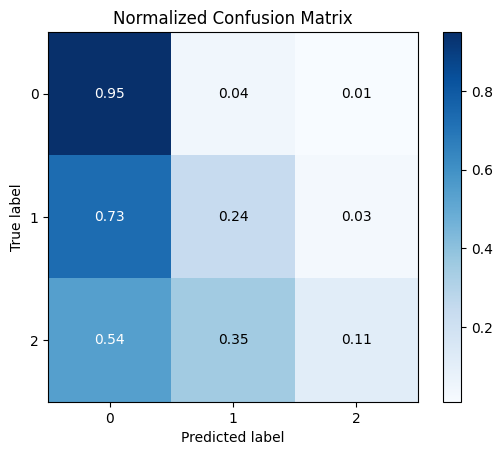

In [322]:
skplt.metrics.plot_confusion_matrix(out["y_label"].tolist(), out["y_pred"].tolist(), normalize=True)

In [323]:
y_pred = grid_lr.predict_proba(X_test)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

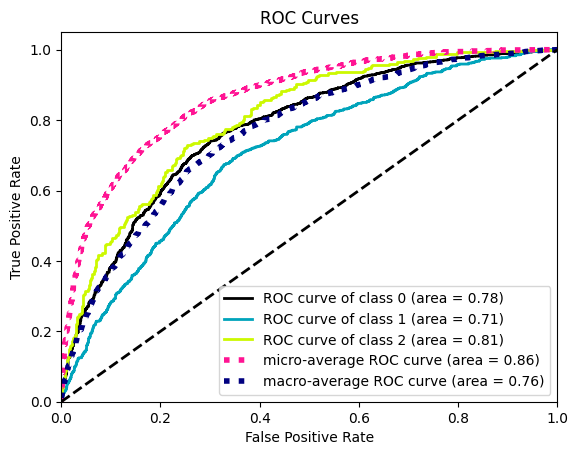

In [324]:
skplt.metrics.plot_roc(y_test.tolist(), y_pred)